## Modeling

### Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.style.use('seaborn-talk')

#fixes jupyter's future warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm

# pip install pmdarima
from pmdarima.arima import auto_arima

In [2]:
springfield = pd.read_csv('data/springfield.csv', index_col='date')
springfield.index = pd.to_datetime(springfield.index)

springfield_diff_2 = pd.read_csv('data/springfield_diff_2.csv', index_col='date')
springfield_diff_2.index = pd.to_datetime(springfield_diff_2.index)

### Train/Test Split

In [3]:
test_cutoff = 220

# dataset that is already .diff() twice
sf_diff_train = springfield_diff_2[0 : test_cutoff]
sf_diff_test = springfield_diff_2[test_cutoff :]

# original working dataset
sf_train = springfield[0 : test_cutoff]
sf_test = springfield[test_cutoff :]

In [28]:
len(sf_diff_test.index)

43

### functions

#### ACF_PACF Charting function

In [4]:
def acf_pacf_charts(df):
    n = len(df.columns)
    fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(12, 25))
    fig.suptitle('Autocorrelations by Zip Code', y=1.03, fontsize=30)

    for i, col in enumerate(springfield_diff_2.columns):
        plot_acf(df[col], ax=axs[i][0], title='ACF: '+col)
        plot_pacf(df[col], ax=axs[i][1], title='PACF: '+col)

    plt.tight_layout()
    fig.subplots_adjust(hspace=.41, wspace=.17)
    plt.show()
    

#### model helper function

In [5]:
 def plot_summary_forecast(arima_mod, test_df, df_col):
    print(arima_mod.summary())
    # forecast
    arima_forecast = arima_mod.forecast(steps=len(test_df))[0]
    
    # plotting forecast vs actual
    plt.figure(figsize=(20,10))

    forecast_df = pd.DataFrame(arima_forecast, test_df.index)

    plt.plot(test_df[df_col])
    plt.plot(forecast_df)

    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title(df_col + ' : Difference in House Sales')
    plt.ylabel('Sales', fontsize=16);
    
    plt.show()

    #RMSE
    RMSE = np.sqrt(mean_squared_error(test_df[df_col], arima_forecast))
    print('RMSE:', round(RMSE), '\n \n \n')

## AR

### ACF and PACF Charts

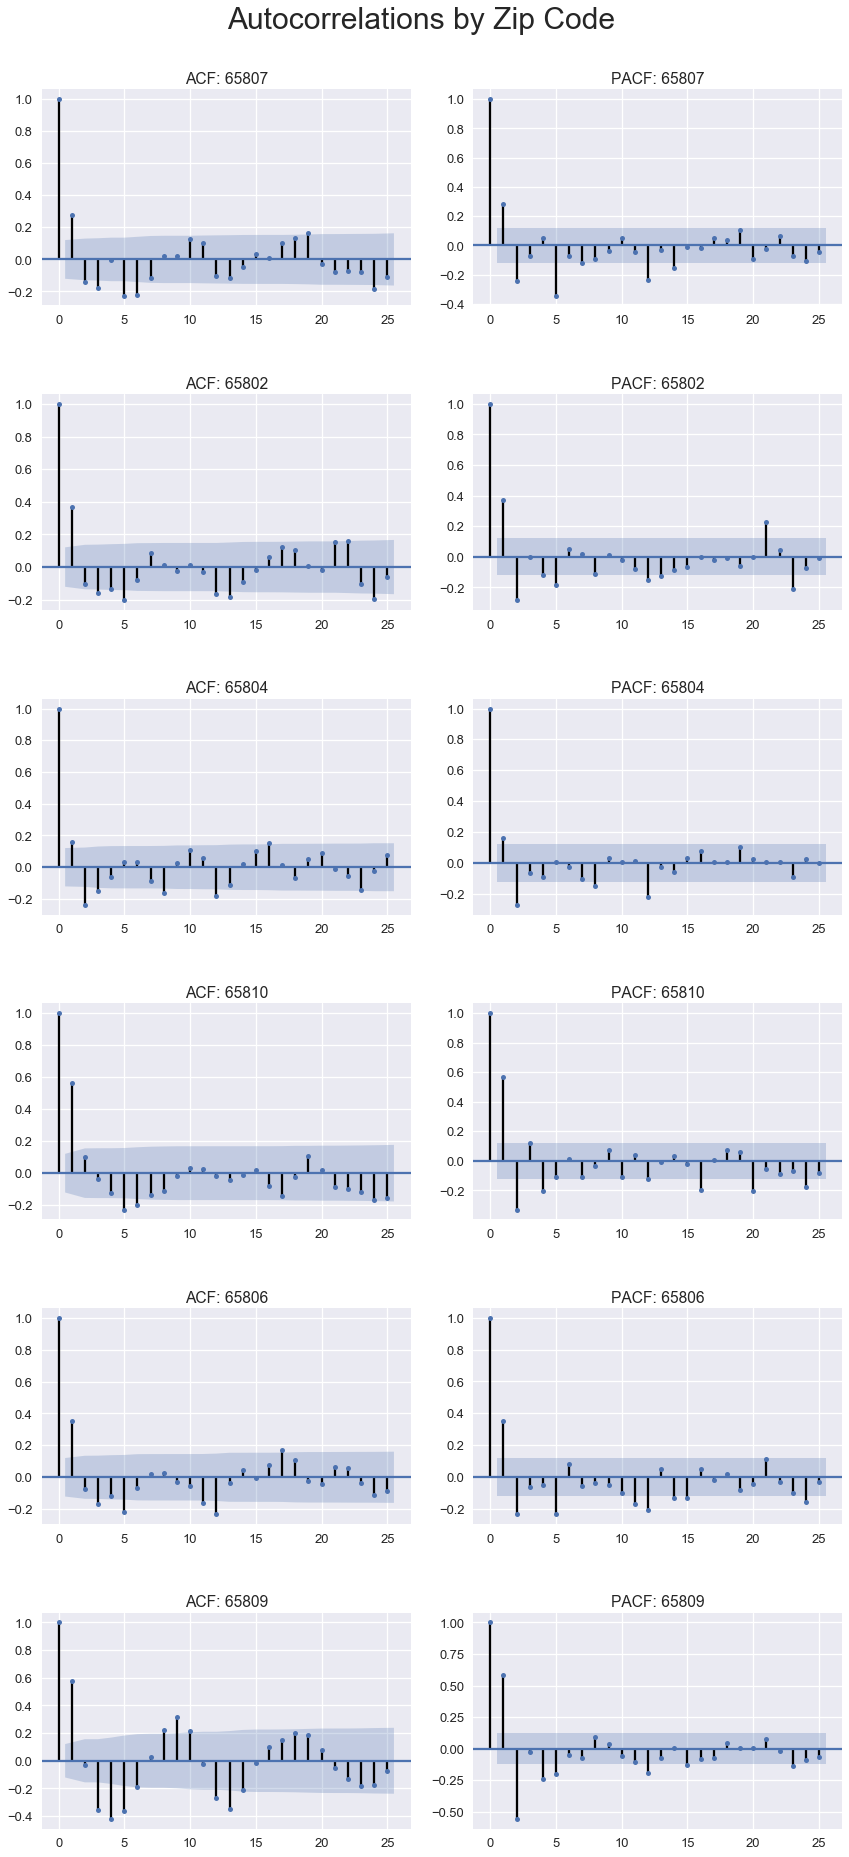

In [6]:
acf_pacf_charts(springfield_diff_2)

### Model

> order is (p,q) p is determined by the AR (pacf), q is determined by the MA (acf)

,65807,65802,65804,65810,65806,65809
Train RMSE,187.175,182.949,182.745,302.38,202.903,670.523
Test RMSE,354.067,286.884,443.861,534.379,344.748,1102.69


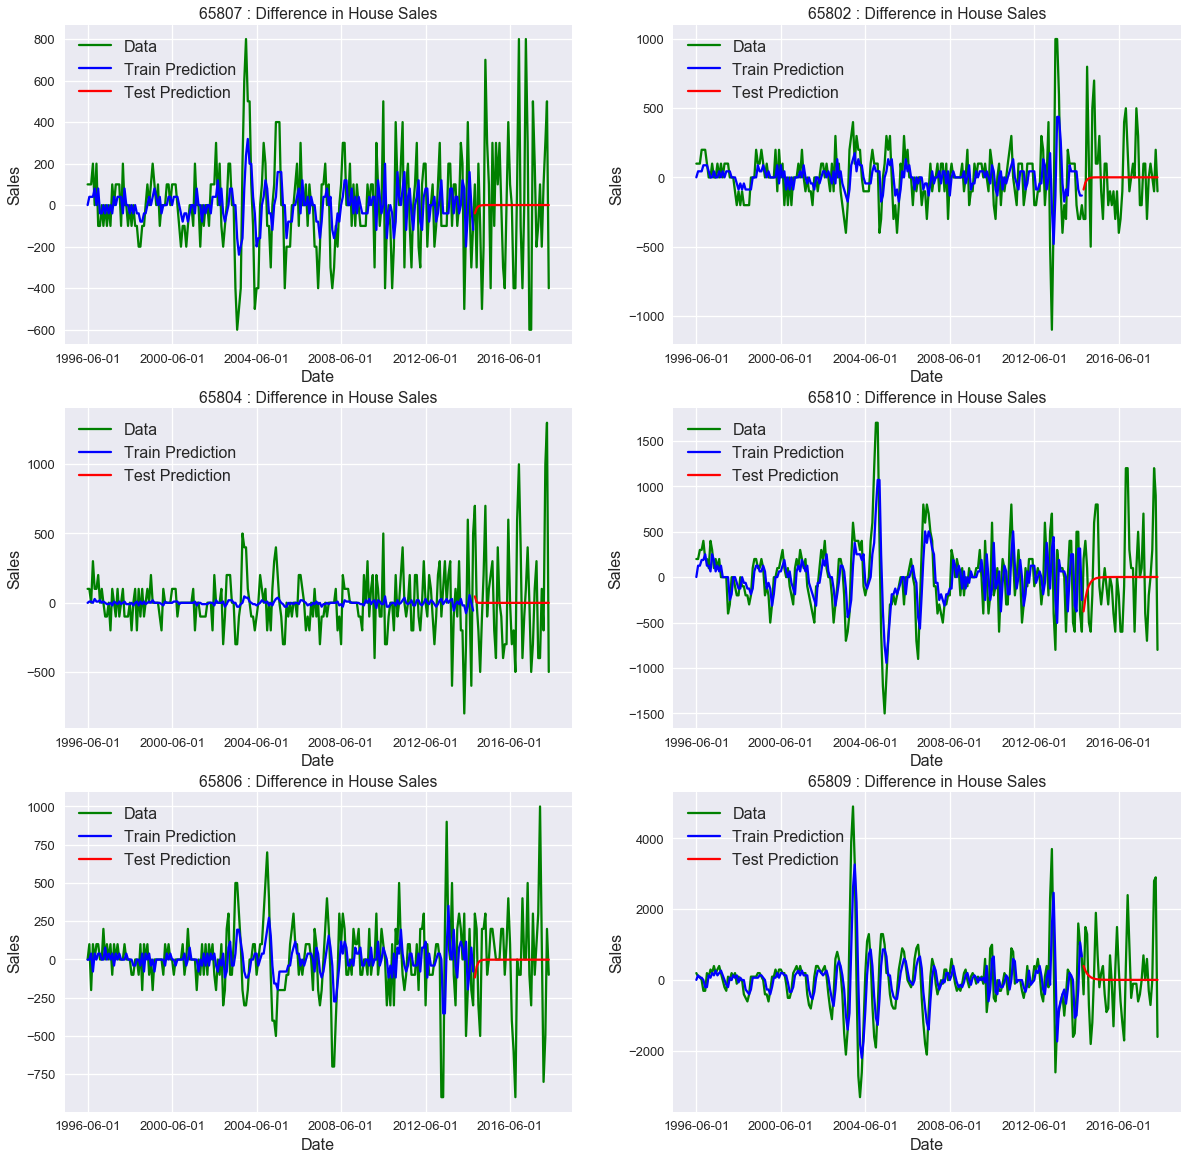

In [27]:
# Results shown in a single figure (subplots)
r,c = 0,-1
graphs = {}
count = 0
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
df_rmse = pd.DataFrame(index=['Train RMSE', 'Test RMSE'], columns=sf_diff_train.columns)
for col in sf_diff_train:
    # creating the ARMA Model
    arma = ARMA(sf_diff_train[col], order=(1,0), freq='MS').fit()
    trainpreds = pd.DataFrame(np.array(arma.predict()), index=sf_diff_train.index)
    testpreds = pd.DataFrame(arma.forecast(len(sf_diff_test))[0], index=sf_diff_test.index)
#     print(arma.summary())
    c += 1
    if c == 2:
        c = 0
        r += 1
    ax[r,c].plot(springfield_diff_2[col], color='green')
    ax[r,c].plot(trainpreds, color ='blue')
    ax[r,c].plot(testpreds, color = 'red')
    ax[r,c].legend(('Data', 'Train Prediction', 'Test Prediction'), fontsize=16)
    ax[r,c].set_title(col + ' : Difference in House Sales')
    ax[r,c].set_ylabel('Sales', fontsize=16);
    ax[r,c].set_xticks(springfield_diff_2.index[range(0, len(springfield_diff_2.index), 48)])
    ax[r,c].set_xlabel('Date', fontsize=16);
    df_rmse.loc['Train RMSE', col] = \
    np.sqrt(mean_squared_error(sf_diff_train[col], arma.predict()))
    df_rmse.loc['Test RMSE', col] = \
    np.sqrt(mean_squared_error(sf_diff_test[col], arma.forecast(len(sf_diff_test))[0]))
    count += 1
df_rmse

                              ARMA Model Results                              
Dep. Variable:                  65807   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1463.280
Method:                       css-mle   S.D. of innovations            187.156
Date:                Fri, 29 Jan 2021   AIC                           2932.560
Time:                        10:44:51   BIC                           2942.741
Sample:                    06-01-1996   HQIC                          2936.671
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4473     20.904      0.021      0.983     -40.524      41.418
ar.L1.65807     0.3982      0.062      6.456      0.000       0.277       0.519
                                    Roots       

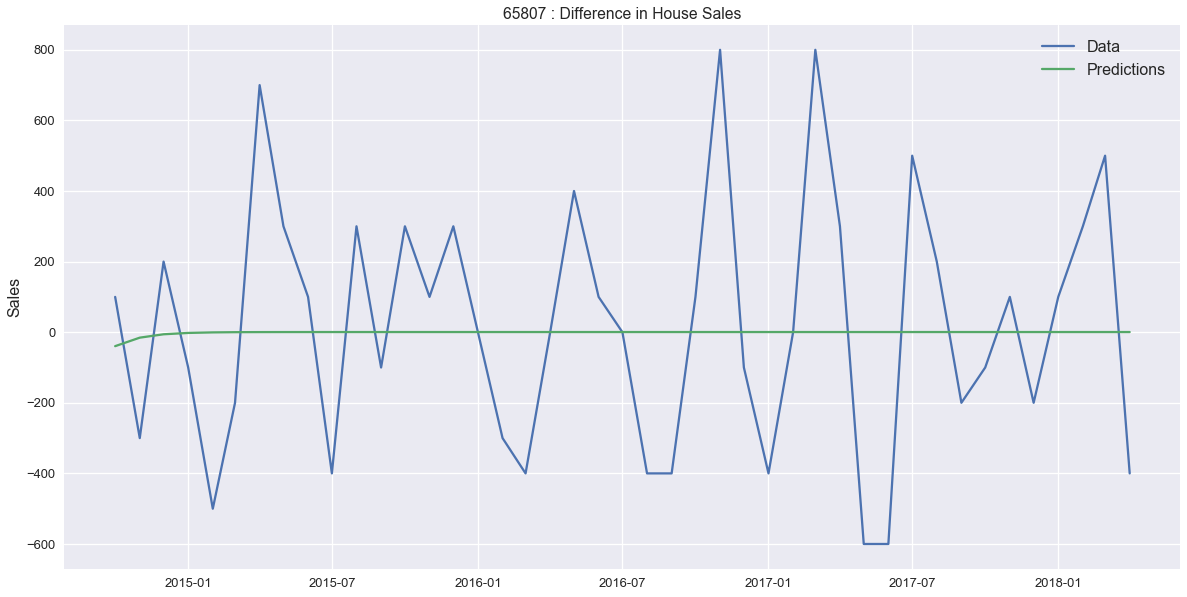

RMSE:  354

 
 

                              ARMA Model Results                              
Dep. Variable:                  65802   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1458.270
Method:                       css-mle   S.D. of innovations            182.925
Date:                Fri, 29 Jan 2021   AIC                           2922.540
Time:                        10:44:51   BIC                           2932.721
Sample:                    06-01-1996   HQIC                          2926.651
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9989     21.839      0.046      0.964     -41.805      43.803
ar.L1.65802     0.4373      0.061      7.219      0.000       0.319       0.556
                               

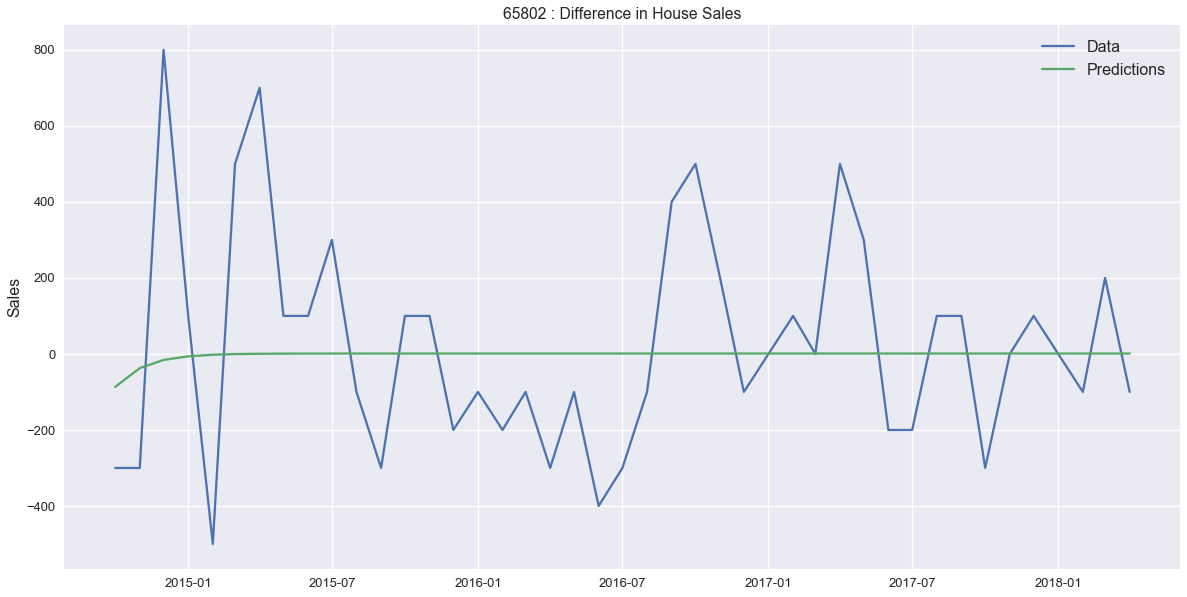

RMSE:  287

 
 

                              ARMA Model Results                              
Dep. Variable:                  65804   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1457.950
Method:                       css-mle   S.D. of innovations            182.744
Date:                Fri, 29 Jan 2021   AIC                           2921.900
Time:                        10:44:52   BIC                           2932.081
Sample:                    06-01-1996   HQIC                          2926.012
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0792     13.582     -0.079      0.937     -27.699      25.540
ar.L1.65804     0.0931      0.068      1.366      0.172      -0.041       0.227
                               

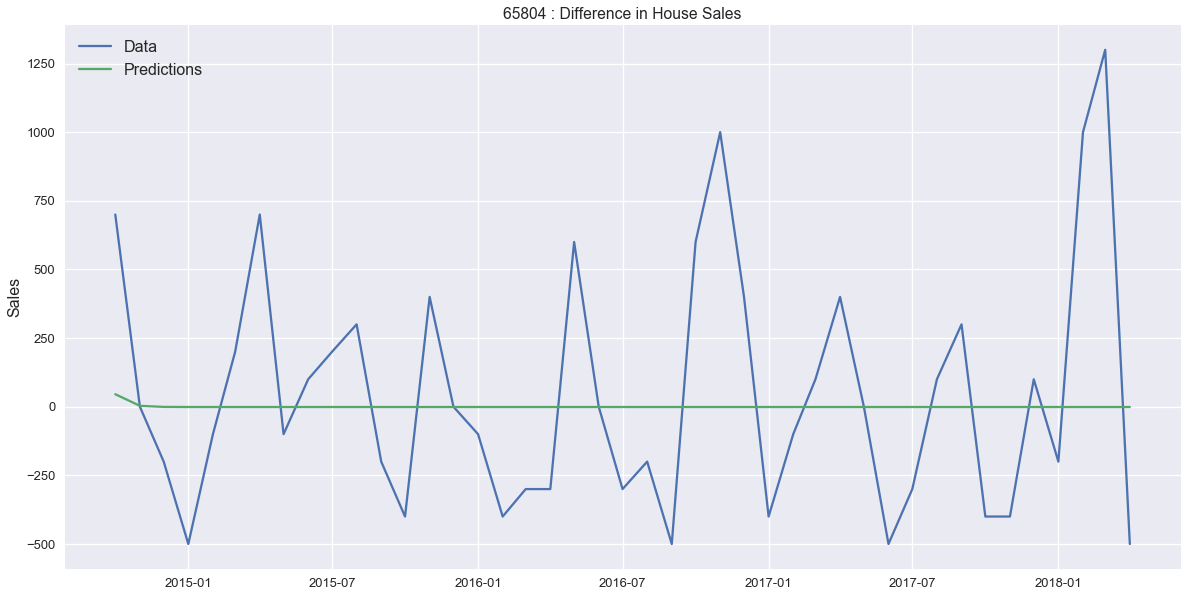

RMSE:  444

 
 

                              ARMA Model Results                              
Dep. Variable:                  65810   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1568.904
Method:                       css-mle   S.D. of innovations            302.264
Date:                Fri, 29 Jan 2021   AIC                           3143.809
Time:                        10:44:53   BIC                           3153.990
Sample:                    06-01-1996   HQIC                          3147.920
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.9284     54.543      0.035      0.972    -104.973     108.830
ar.L1.65810     0.6292      0.052     11.985      0.000       0.526       0.732
                               

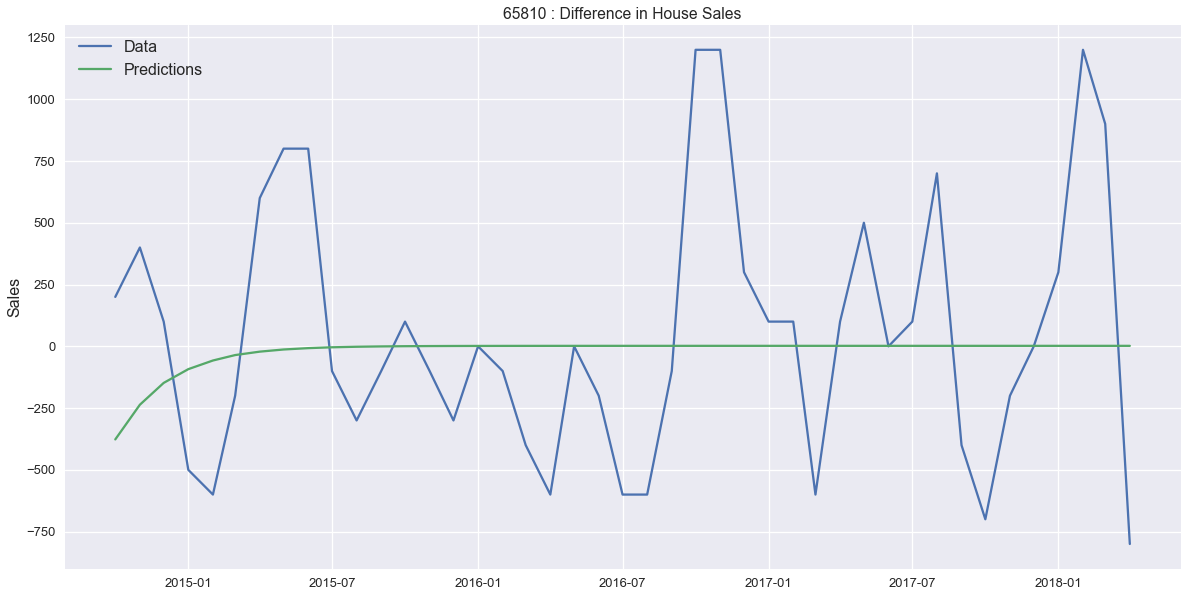

RMSE:  534

 
 

                              ARMA Model Results                              
Dep. Variable:                  65806   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1481.049
Method:                       css-mle   S.D. of innovations            202.903
Date:                Fri, 29 Jan 2021   AIC                           2968.098
Time:                        10:44:54   BIC                           2978.279
Sample:                    06-01-1996   HQIC                          2972.209
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3249     22.387     -0.059      0.953     -45.202      42.552
ar.L1.65806     0.3907      0.062      6.288      0.000       0.269       0.512
                               

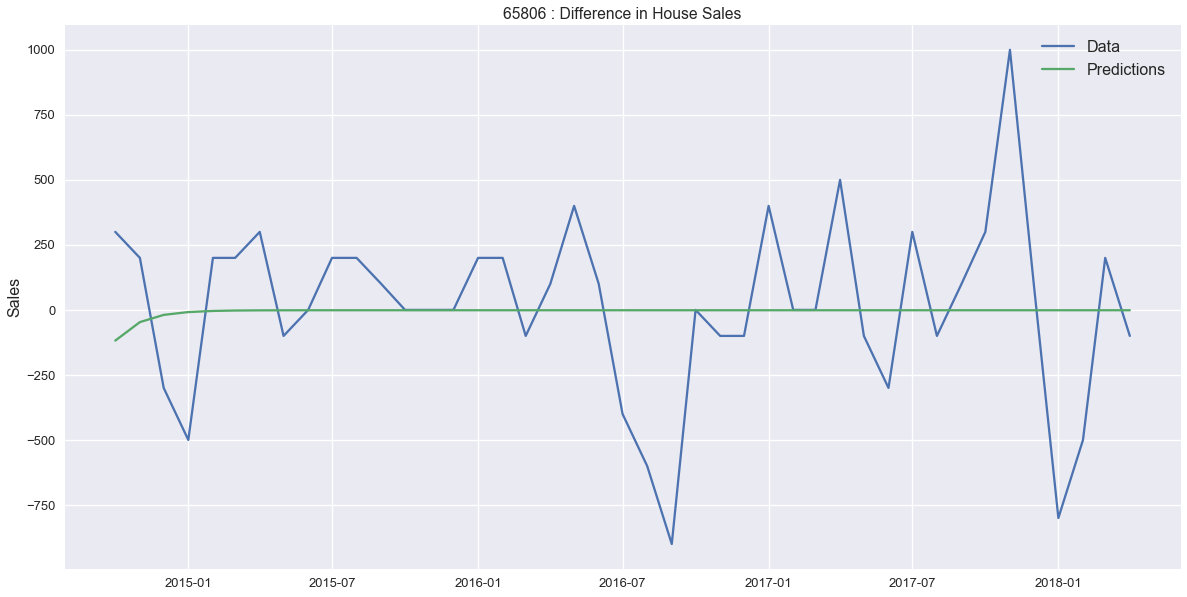

RMSE:  345

 
 

                              ARMA Model Results                              
Dep. Variable:                  65809   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1744.213
Method:                       css-mle   S.D. of innovations            670.468
Date:                Fri, 29 Jan 2021   AIC                           3494.427
Time:                        10:44:54   BIC                           3504.608
Sample:                    06-01-1996   HQIC                          3498.538
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.4638    133.856      0.063      0.950    -253.889     270.817
ar.L1.65809     0.6653      0.050     13.315      0.000       0.567       0.763
                               

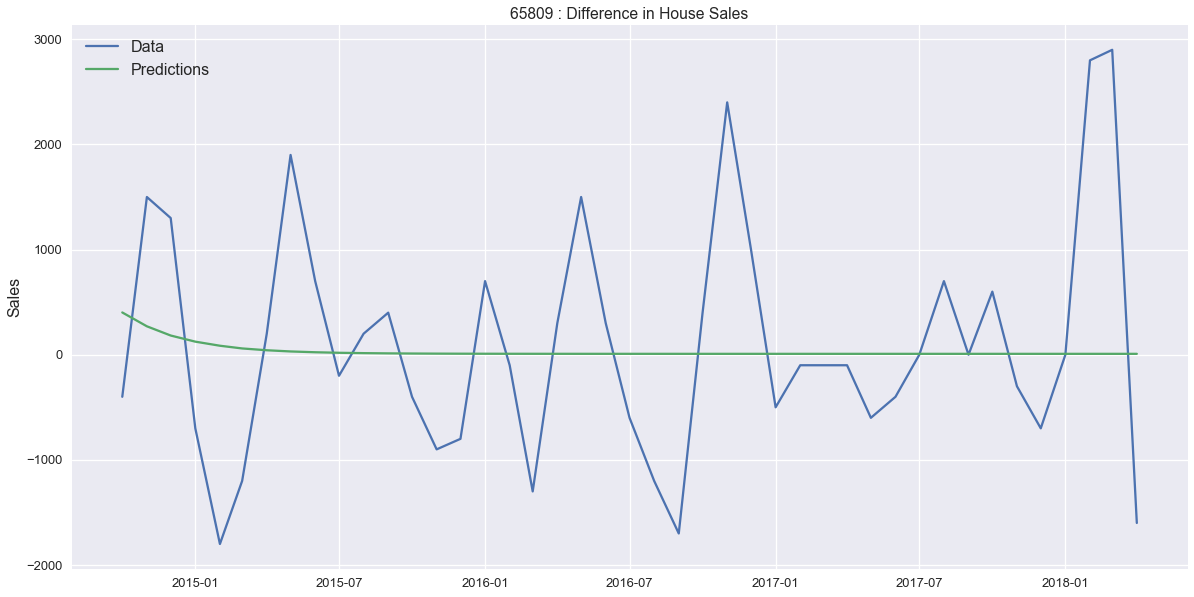

RMSE:  1103

 
 



In [17]:
for col in sf_diff_train:
    
    #creating the ARMA Model
    arma = ARMA(sf_diff_train[col], order=(1,0), freq='MS').fit()
    print(arma.summary())
    
    arma_forecast = arma.forecast(steps=len(sf_diff_test[col]))[0]
    RMSE = np.sqrt(mean_squared_error(sf_diff_test[col], arma_forecast))
    
    # plotting forecast vs actual
    plt.figure(figsize=(20,10))

    forecast_df = pd.DataFrame(arma_forecast, sf_diff_test.index)
    
    plt.plot(sf_diff_test[col])
    plt.plot(forecast_df)

    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title(col + ' : Difference in House Sales')
    plt.ylabel('Sales', fontsize=16);
    
    plt.show()

    print('RMSE: ', round(RMSE))
    print('\n \n \n')

## ARIMA (Base)

### ACF and PACF Charts

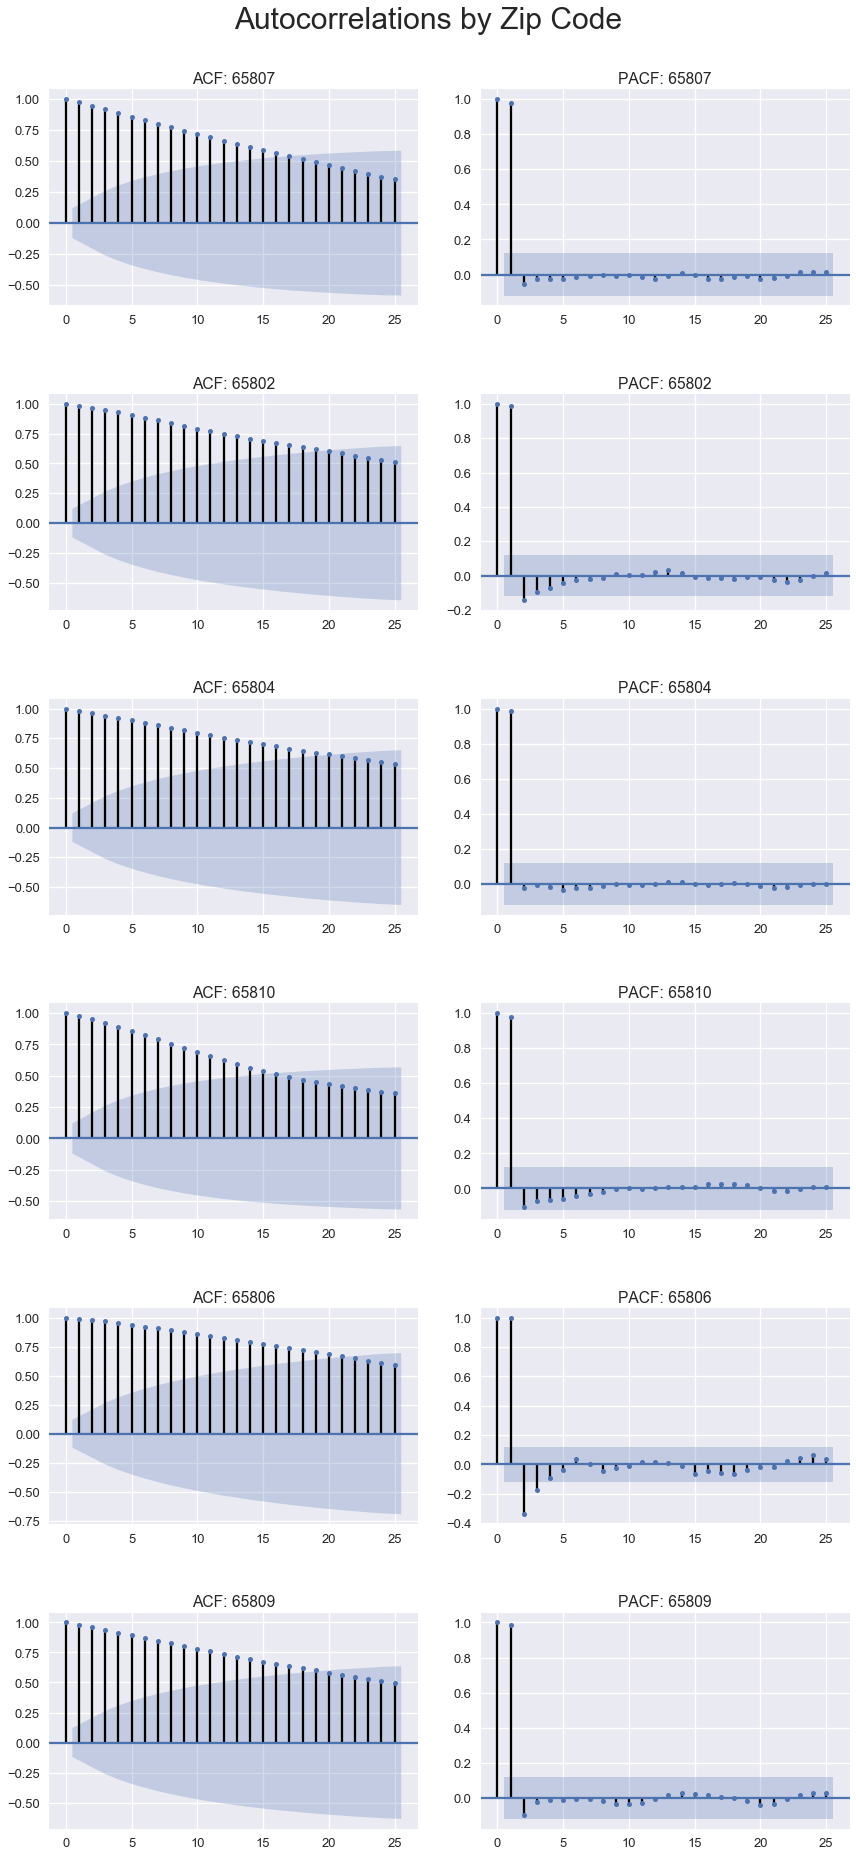

In [18]:
acf_pacf_charts(springfield)

### Model

                             ARIMA Model Results                              
Dep. Variable:               D2.65807   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1449.680
Method:                       css-mle   S.D. of innovations            186.900
Date:                Fri, 29 Jan 2021   AIC                           2905.361
Time:                        10:45:02   BIC                           2915.514
Sample:                    06-01-1996   HQIC                          2909.462
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.5787     20.990      0.123      0.902     -38.562      43.719
ar.L1.D2.65807     0.3988      0.062      6.442      0.000       0.277       0.520
                                    

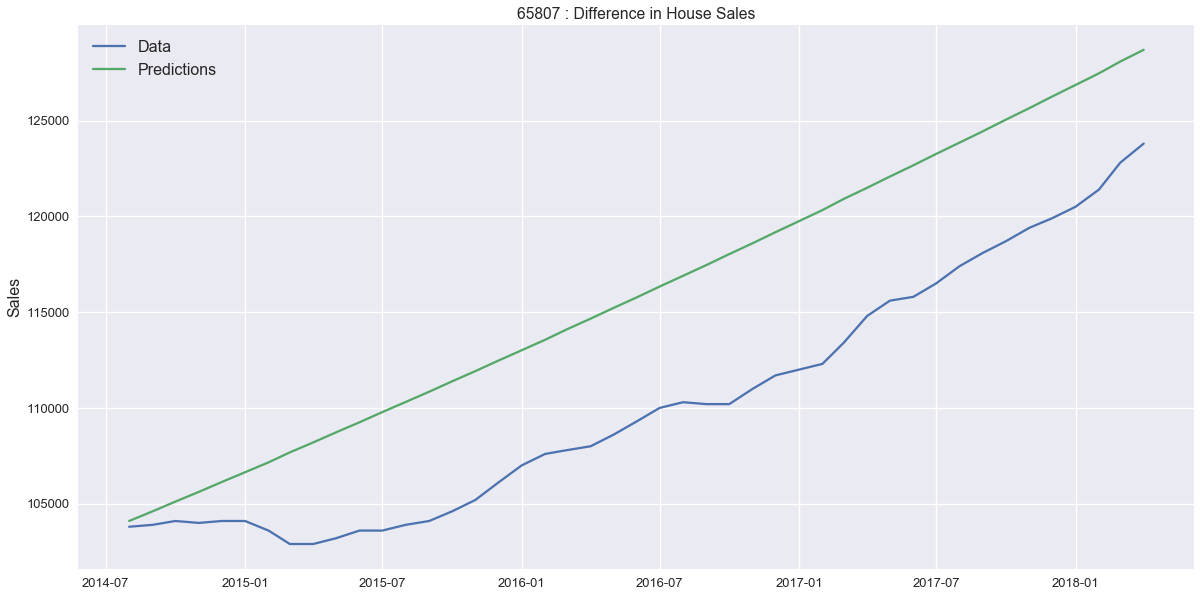

RMSE: 6039 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65802   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1445.499
Method:                       css-mle   S.D. of innovations            183.337
Date:                Fri, 29 Jan 2021   AIC                           2896.999
Time:                        10:45:03   BIC                           2907.152
Sample:                    06-01-1996   HQIC                          2901.100
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.9623     21.677      0.137      0.891     -39.524      45.449
ar.L1.D2.65802     0.4291      0.061      6.997      0.000       0.309       0.549
                   

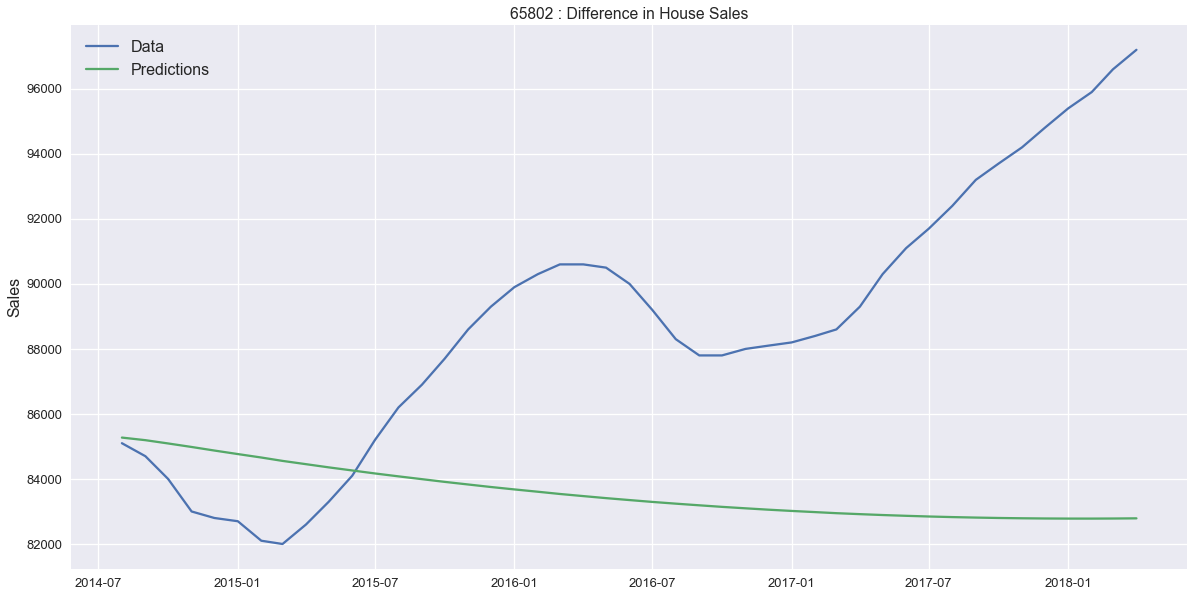

RMSE: 6989 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65804   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1435.018
Method:                       css-mle   S.D. of innovations            174.804
Date:                Fri, 29 Jan 2021   AIC                           2876.036
Time:                        10:45:03   BIC                           2886.190
Sample:                    06-01-1996   HQIC                          2880.137
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8400     13.791     -0.061      0.951     -27.870      26.190
ar.L1.D2.65804     0.1422      0.067      2.124      0.034       0.011       0.273
                   

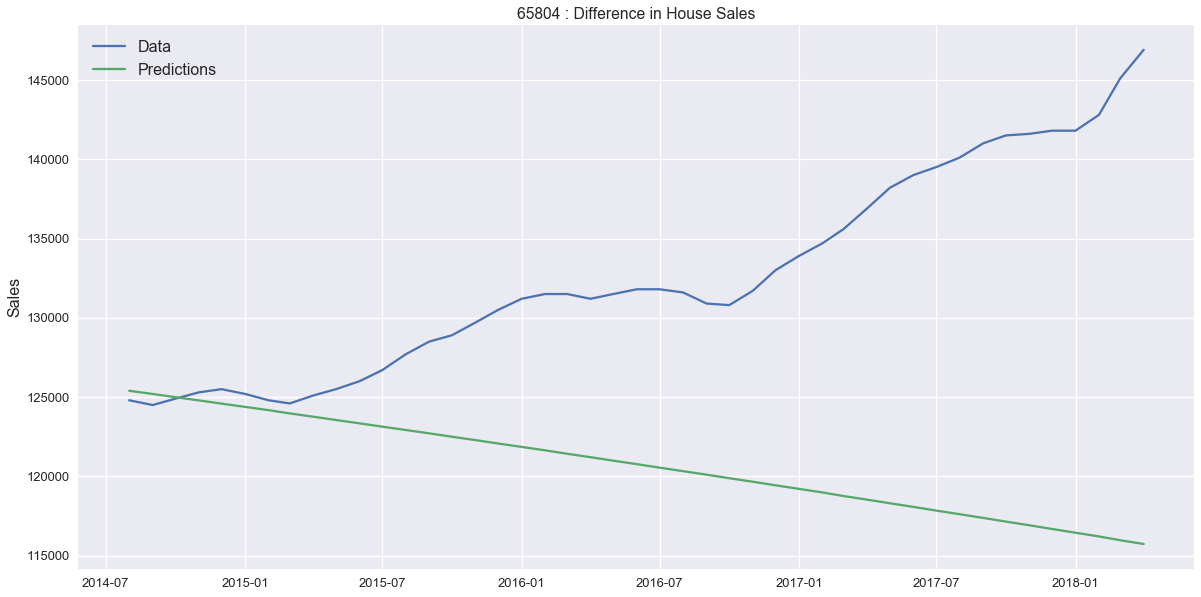

RMSE: 15010 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65810   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1552.112
Method:                       css-mle   S.D. of innovations            298.764
Date:                Fri, 29 Jan 2021   AIC                           3110.225
Time:                        10:45:04   BIC                           3120.378
Sample:                    06-01-1996   HQIC                          3114.326
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             14.9844     55.119      0.272      0.786     -93.047     123.016
ar.L1.D2.65810     0.6357      0.052     12.176      0.000       0.533       0.738
                  

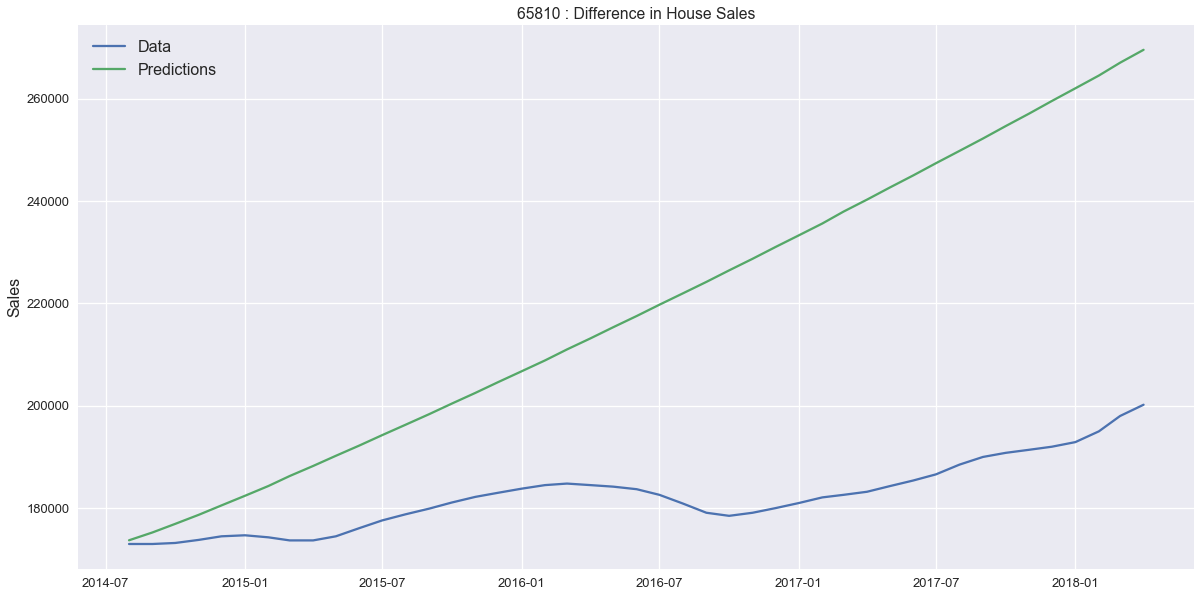

RMSE: 42890 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65806   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1467.043
Method:                       css-mle   S.D. of innovations            202.398
Date:                Fri, 29 Jan 2021   AIC                           2940.086
Time:                        10:45:05   BIC                           2950.239
Sample:                    06-01-1996   HQIC                          2944.187
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.4109     22.470      0.107      0.915     -41.629      46.450
ar.L1.D2.65806     0.3917      0.062      6.297      0.000       0.270       0.514
                  

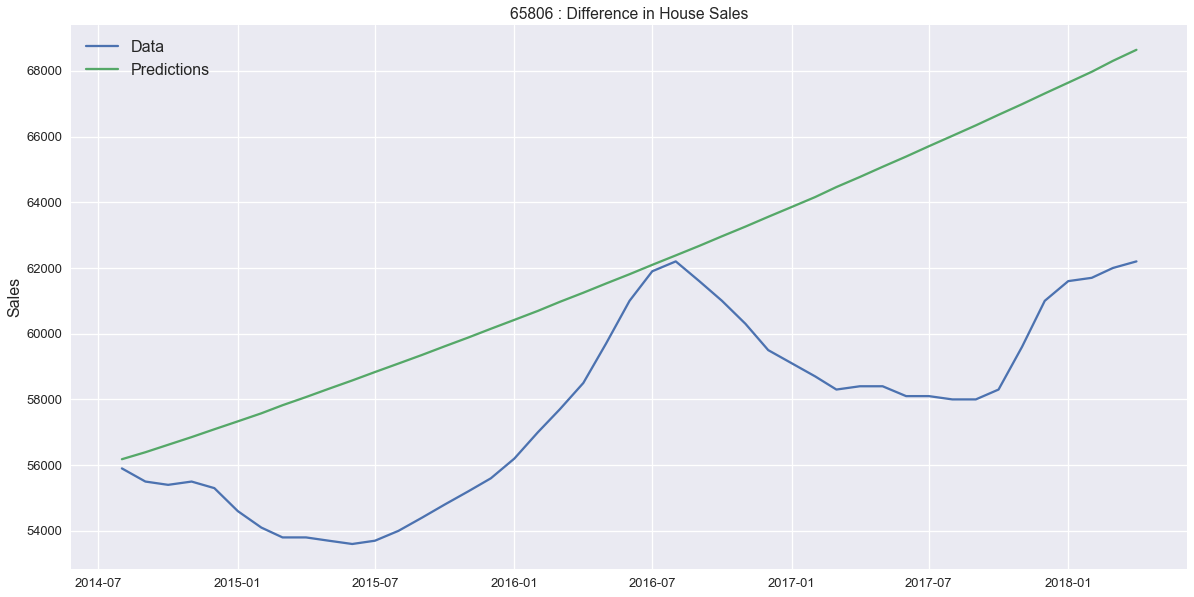

RMSE: 4889 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65809   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1729.345
Method:                       css-mle   S.D. of innovations            673.501
Date:                Fri, 29 Jan 2021   AIC                           3464.689
Time:                        10:45:05   BIC                           3474.843
Sample:                    06-01-1996   HQIC                          3468.790
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.2561    135.496      0.076      0.940    -255.310     275.823
ar.L1.D2.65809     0.6663      0.051     13.143      0.000       0.567       0.766
                   

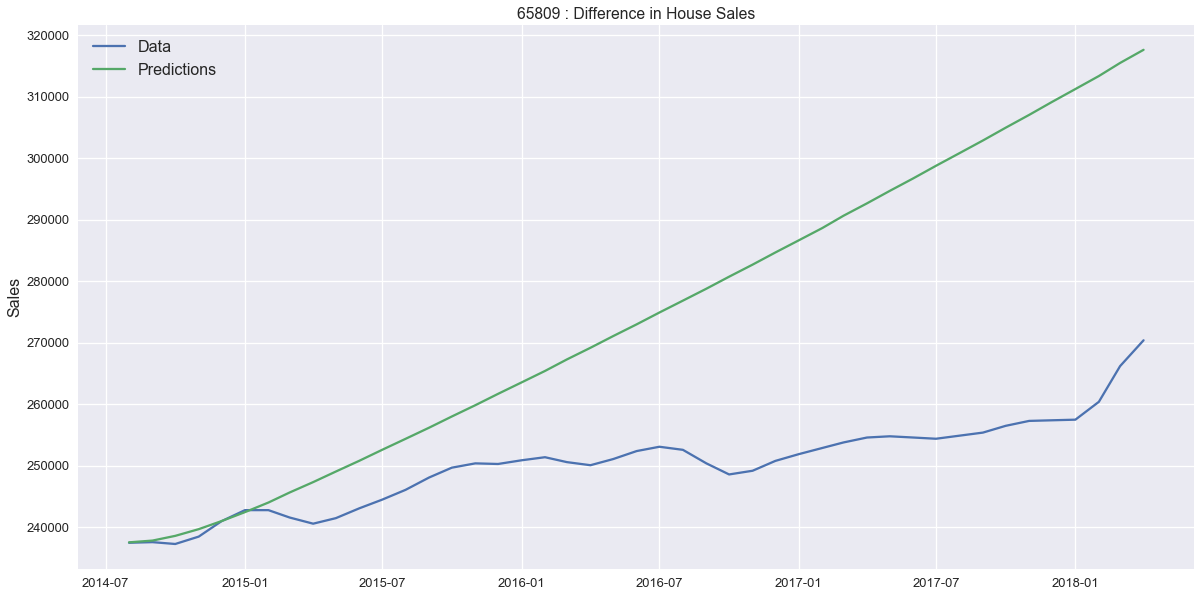

RMSE: 29993 
 
 



In [19]:
for col in sf_train:
    # model
    arima = ARIMA(sf_train[col], order= (1,2,0), freq='MS').fit()

    plot_summary_forecast(arima, sf_test, col)


## Auto-ARIMA

### Model

In [20]:
order_dict = {}

In [21]:
for col in sf_train:
    auto = auto_arima(sf_train[col], max_order=None, max_p=10, max_q=10, d=2, max_d=5, information_criterion='aic')
    
    order_dict[col] = auto.get_params()['order']
    
    print(col)
    print(auto.summary(), '\n\n\n')

65807
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -1446.488
Date:                Fri, 29 Jan 2021   AIC                           2902.977
Time:                        10:45:15   BIC                           2919.899
Sample:                             0   HQIC                          2909.812
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4201      0.065     21.828      0.000       1.293       1.548
ar.L2         -0.8737      0.054    -16.073      0.000      -0.980      -0.767
ma.L1         -1.2821      0.077    -16.666   

65809
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -1790.378
Date:                Fri, 29 Jan 2021   AIC                           3584.757
Time:                        10:45:24   BIC                           3591.526
Sample:                             0   HQIC                          3587.491
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0336      0.007      4.835      0.000       0.020       0.047
sigma2      7.774e+05   3.49e+04     22.302      0.000    7.09e+05    8.46e+05
Ljung-Box (Q):                      462.58   J

In [22]:
order_dict

{'65807': (2, 2, 2),
 '65802': (2, 2, 1),
 '65804': (2, 2, 2),
 '65810': (2, 2, 2),
 '65806': (0, 2, 1),
 '65809': (1, 2, 0)}

## ARIMA (Final)

### Model

                             ARIMA Model Results                              
Dep. Variable:               D2.65807   No. Observations:                  218
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1433.957
Method:                       css-mle   S.D. of innovations            173.579
Date:                Fri, 29 Jan 2021   AIC                           2879.914
Time:                        10:45:25   BIC                           2900.221
Sample:                    06-01-1996   HQIC                          2888.116
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1920      5.692      0.034      0.973     -10.963      11.347
ar.L1.D2.65807     1.5038      0.083     18.189      0.000       1.342       1.666
ar.L2.D2.65807    -0.7217      0.083

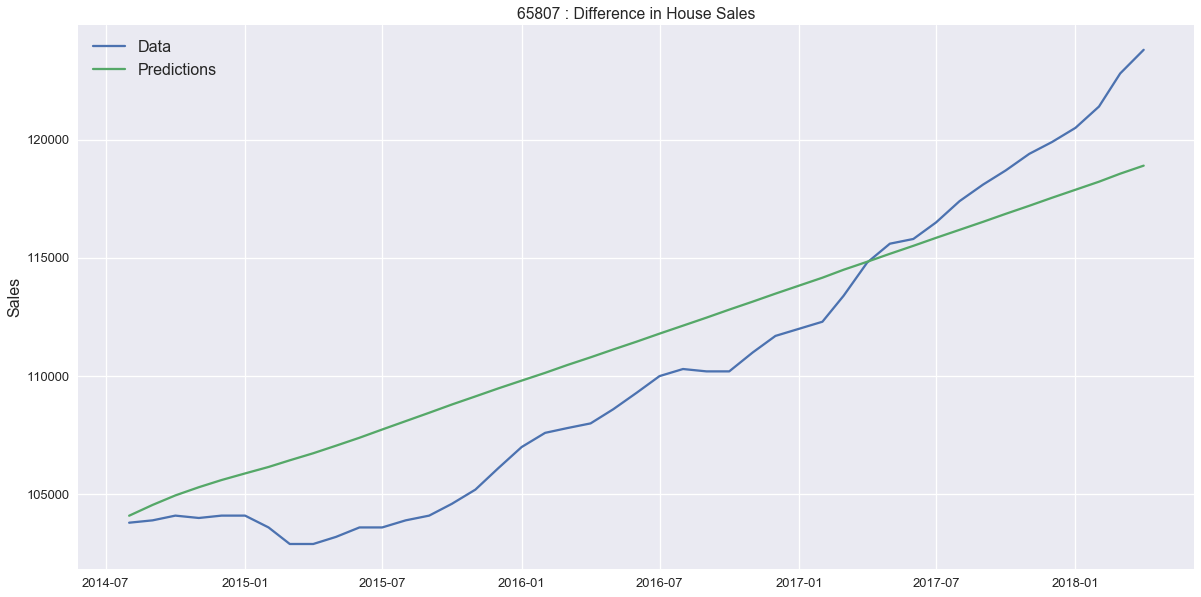

RMSE: 2674 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65802   No. Observations:                  218
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1429.349
Method:                       css-mle   S.D. of innovations            170.090
Date:                Fri, 29 Jan 2021   AIC                           2868.697
Time:                        10:45:25   BIC                           2885.620
Sample:                    06-01-1996   HQIC                          2875.533
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.0913      9.578      0.323      0.747     -15.681      21.864
ar.L1.D2.65802     1.1181      0.114      9.779      0.000       0.894       1.342
ar.L2.D2.65802    -

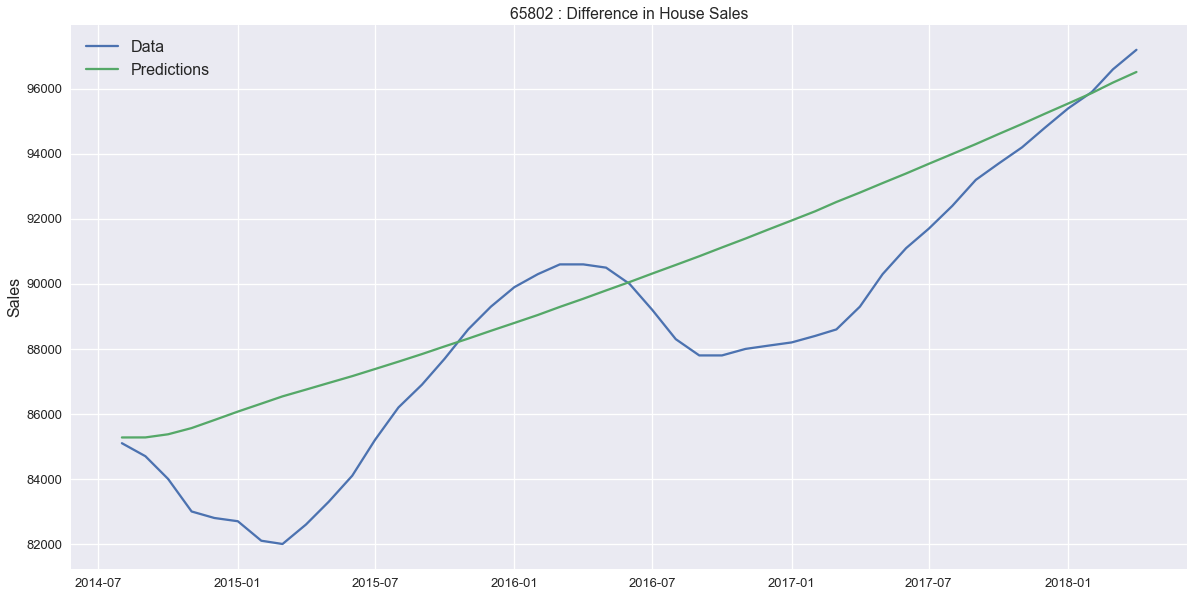

RMSE: 2370 
 
 

AR p-value too high, lowered order from (2, 2, 2)
                             ARIMA Model Results                              
Dep. Variable:               D2.65804   No. Observations:                  218
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1429.591
Method:                       css-mle   S.D. of innovations            169.466
Date:                Fri, 29 Jan 2021   AIC                           2869.183
Time:                        10:45:27   BIC                           2886.105
Sample:                    06-01-1996   HQIC                          2876.018
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.4151      1.689     -1.430      0.153      -5.725       0.894
ar.L1.D2.65804     0.8823      0.036     24.261     

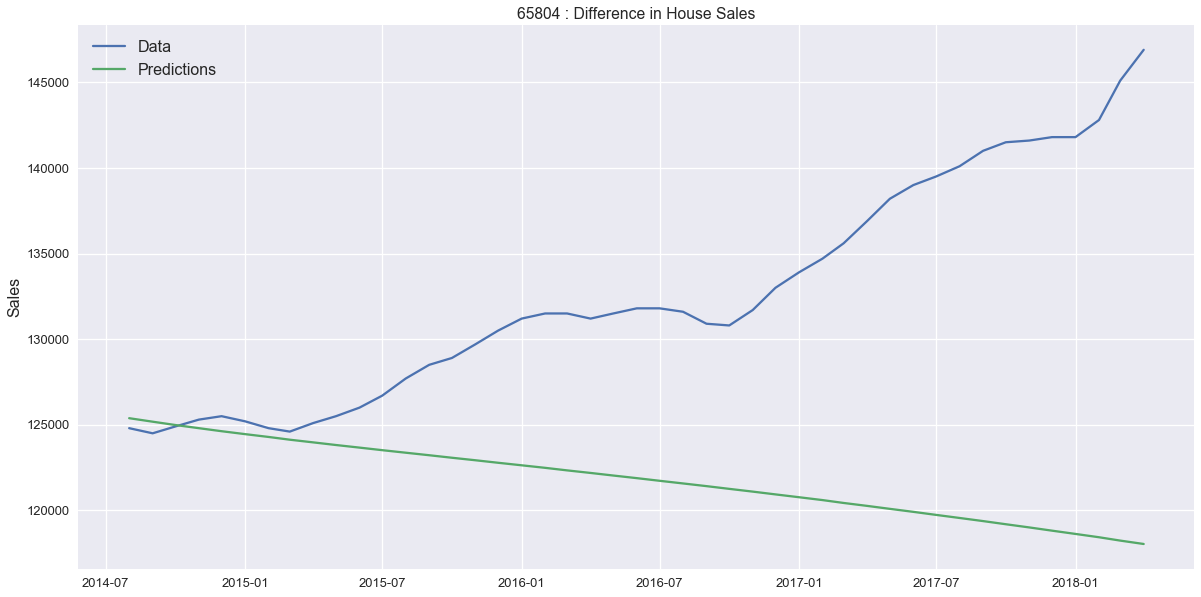

RMSE: 13689 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65810   No. Observations:                  218
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1532.227
Method:                       css-mle   S.D. of innovations            270.601
Date:                Fri, 29 Jan 2021   AIC                           3076.454
Time:                        10:45:27   BIC                           3096.761
Sample:                    06-01-1996   HQIC                          3084.656
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.3068      3.717     -0.352      0.725      -8.592       5.978
ar.L1.D2.65810     1.3789      0.082     16.774      0.000       1.218       1.540
ar.L2.D2.65810    

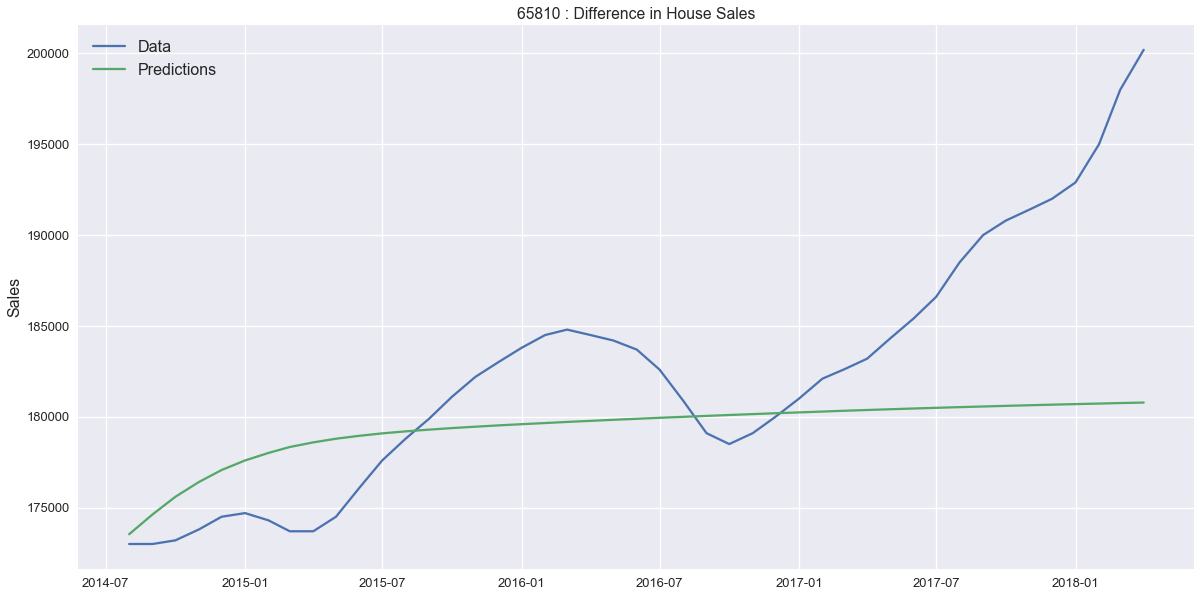

RMSE: 6495 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65806   No. Observations:                  218
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1466.820
Method:                       css-mle   S.D. of innovations            202.198
Date:                Fri, 29 Jan 2021   AIC                           2939.639
Time:                        10:45:28   BIC                           2949.793
Sample:                    06-01-1996   HQIC                          2943.740
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.0335     18.789      0.108      0.914     -34.791      38.858
ma.L1.D2.65806     0.3737      0.052      7.248      0.000       0.273       0.475
                   

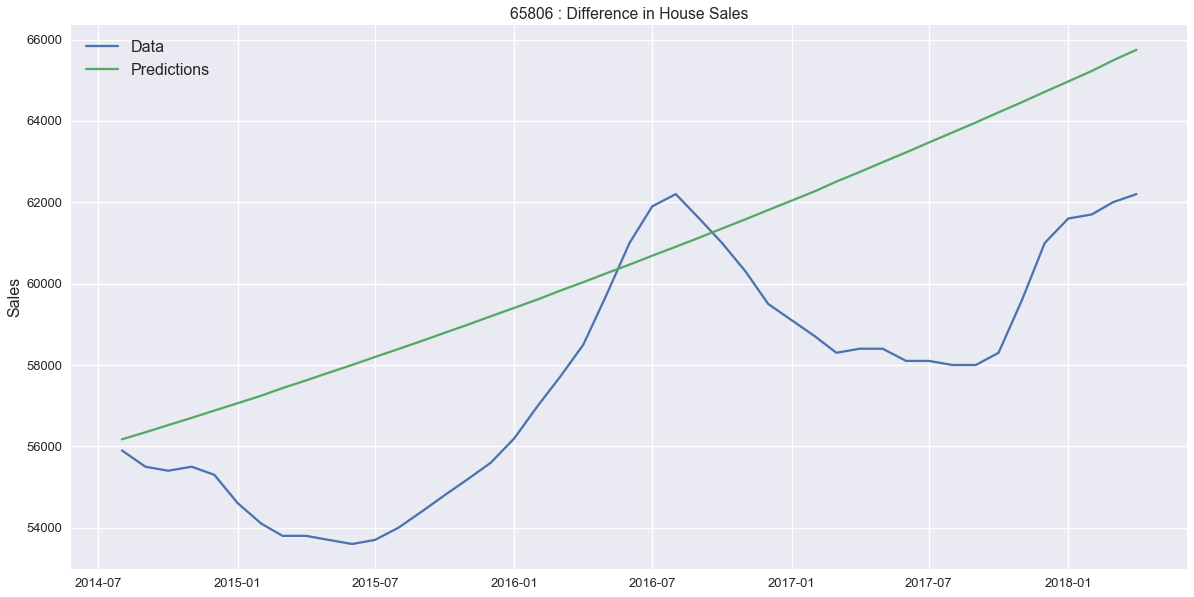

RMSE: 3478 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65809   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1729.345
Method:                       css-mle   S.D. of innovations            673.501
Date:                Fri, 29 Jan 2021   AIC                           3464.689
Time:                        10:45:29   BIC                           3474.843
Sample:                    06-01-1996   HQIC                          3468.790
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.2561    135.496      0.076      0.940    -255.310     275.823
ar.L1.D2.65809     0.6663      0.051     13.143      0.000       0.567       0.766
                   

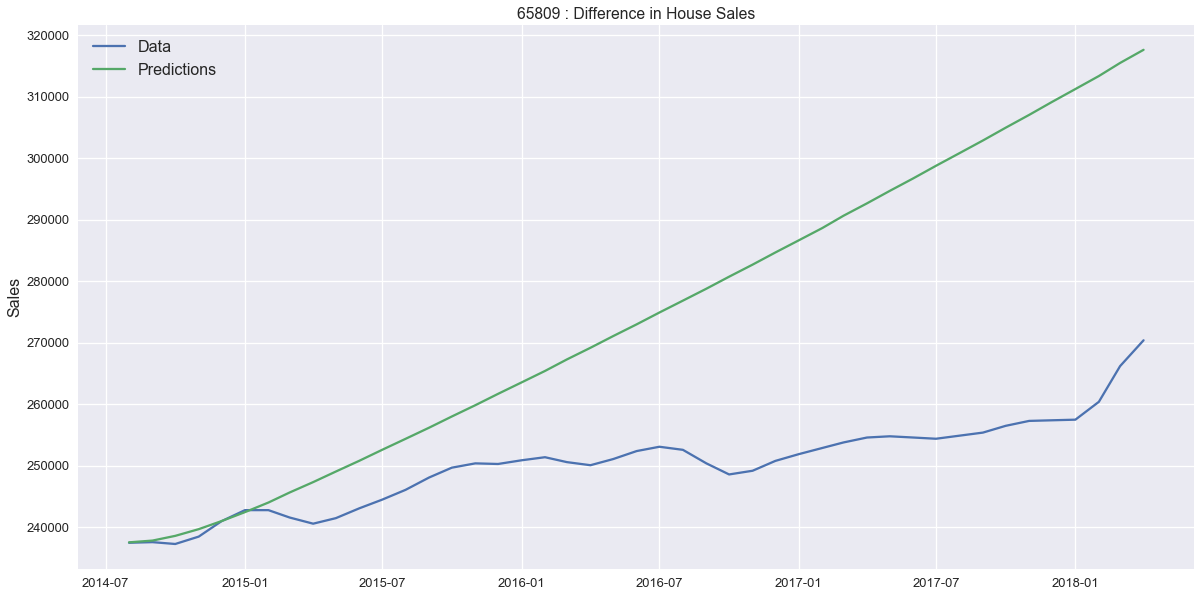

RMSE: 29993 
 
 



In [23]:
ar_substring = 'ar'
ma_substring = 'ma'


for col in sf_train:
    
    arima = ARIMA(sf_train[col], order=order_dict[col] , freq='MS').fit()
    
    
    arima_flag = False
    
    # looping until high p-values are eliminated
    while arima_flag == False:
        
        # loop determining if new order is needed
        for i in range(len(arima.pvalues)):
            
            # new order is needed
            if (i>0) and (arima.pvalues[i] > .05):
                
                # ar causing high p-value
                if ar_substring in arima.pvalues.index[i]:
                    print('AR p-value too high, lowered order from', order_dict[col])
                    order_dict[col] = np.subtract(order_dict[col], (1,0,0))
                    arima = ARIMA(sf_train[col], order=order_dict[col] , freq='MS').fit()
                    break
                    
                # ma causing high p-value
                elif ma_substring in arima.pvalues.index[i]:
                    print('MA p-value too high, lowered order from', order_dict[col])
                    order_dict[col] = np.subtract(order_dict[col], (0,0,1))
                    arima = ARIMA(sf_train[col], order=order_dict[col] , freq='MS').fit()
                    break
            
            # current order has no p_values (exit while loop)
            elif i == len(arima.pvalues)-1:
                arima_flag = True
            
    
    plot_summary_forecast(arima, sf_test, col)